#COS575 Lab 6
##Tatiana Romanchishina

In [1]:
# load numpy and pandas for data manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
#%pylab inline

from pylab import *

# load statsmodels
import statsmodels.api as sm

from sklearn import metrics

from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA
from sklearn.neighbors import KNeighborsClassifier

from collections import OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix as sk_confusion_matrix
from patsy import dmatrices
from sklearn.cross_validation import cross_val_score
from sklearn import preprocessing


# load the data
path = r'CHR2015.csv'
df = pd.read_csv(path)
df.head()

,STATECODE,COUNTYCODE,State,County,Premature_death_Value,Poor_or_fair_health_Value,Poor_physical_health_days_Value,Poor_mental_health_days_Value,Low_birthweight_Value,Adult_smoking_Value,...,Uninsured_adults_Value,Uninsured_children_Value,Health_care_costs_Value,Could_not_see_doctor_due_to_cost_Value,Other_primary_care_providers_Value,Median_household_income_Value,Children_eligible_for_free_lunch_Value,Homicide_rate_Value,bottom10,top10
0,1,0,AL,Alabama,9508,0.205,4.3,4.3,0.10,0.219,...,0.202,0.043,10127,0.163,48,42882,0.500,9.1,0,0
1,1,1,AL,Autauga County,8405,0.228,5.1,3.6,0.09,0.217,...,0.169,0.037,9939,0.156,18,51868,0.383,4.6,0,0
2,1,3,AL,Baldwin County,7457,0.127,3.3,3.8,0.09,0.206,...,0.199,0.054,9502,0.144,29,47539,0.344,4.3,0,0
3,1,5,AL,Barbour County,8901,0.234,4.8,4.3,0.12,0.251,...,0.228,0.045,10414,0.169,11,30981,0.697,NaN,0,0
4,1,7,AL,Bibb County,10729,0.179,4.7,5.1,0.13,0.259,...,0.193,0.042,10825,0.163,9,39781,0.546,7.8,0,0


In [2]:
# add the response column 
df['aboveMedianPDV'] = [1 if d <= np.median(df['Premature_death_Value']) else 0 for d in df['Premature_death_Value']]
print(len(df[df.aboveMedianPDV == 0]), len(df[df.aboveMedianPDV == 1]), df.shape)

1524 1524 (3048, 71)


In [3]:
# remove NaNs
df_fix = df[~np.isnan(df.Adult_smoking_Value) & ~np.isnan(df.Adult_obesity_Value) &
           ~np.isnan(df.Physical_inactivity_Value) & ~np.isnan(df.Diabetes_Value) &
            ~np.isnan(df.Teen_births_Value) & ~np.isnan(df.aboveMedianPDV)]
df_fix = df_fix.reset_index(drop=True)
df_fix[['Adult_smoking_Value', 'Adult_obesity_Value', 'Physical_inactivity_Value', 
             'Diabetes_Value', 'Teen_births_Value']].isnull().sum()

Adult_smoking_Value          0
Adult_obesity_Value          0
Physical_inactivity_Value    0
Diabetes_Value               0
Teen_births_Value            0
dtype: int64

In [4]:
# create dataframes with an intercept column
y, X = dmatrices('aboveMedianPDV ~ Adult_smoking_Value + Adult_obesity_Value + \
                 Physical_inactivity_Value + Diabetes_Value + \
                 Teen_births_Value',
                df_fix, return_type="dataframe")
# flatten y into a 1-D array
#y = np.ravel(y) #OR
y = y.values.flatten()

####We ran the KNN algorithm, but we were unsure about the number of neighbors to include. With the above tutorials, we now have the techniques to make that choice. Select one of your KNN runs (with some subset of predictors) and determine the best value for the number of neighbors. 
####Plot ‘# of neighbors’ vs. train and test accuracy

##### Note: This can be done by either using two separate plots or by using one plot with  different formatting styles to distinguish the Y values. 

In [5]:
# obtain train and test errors for different ks
ks = [1,5,10,25,50,75,100]
train_errs = {}
test_errs = {}
for k in ks:
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                        test_size=.4, random_state=1)
    model = KNeighborsClassifier(n_neighbors=k)
    
    train_errs[k] = 1 - model.fit(X_train, y_train).score(X_train, y_train)
    
    predicted = model.predict(X_test)
    test_errs[k] = 1 - metrics.accuracy_score(y_test, predicted)


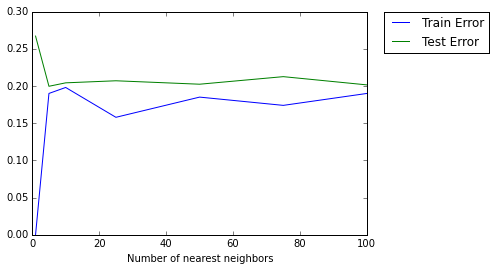

In [6]:
# plot train and test errors 
plt.plot(ks, list(train_errs.values()), label = "Train Error")
plt.plot(ks, list(test_errs.values()), label = "Test Error")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Number of nearest neighbors")
plt.show()

####We will now consider the calculating estimates of the mean & median for Premature_death_Value. Based on this data set, provide an estimate for the population mean of Premature_death_value. Call this estimate μ_est.

In [7]:
mu_est = mean(df.Premature_death_Value)
mu_est

7980.833989501312

####Provide an estimate of the standard error of μ_est. Interpret this result. Hint: We can compute the standard error of the sample mean by dividing the sample standard deviation by the square root of the number of observations.

In [8]:
shape(df)[0]

3048

In [9]:
# 2 --> divide std dev by the sq rt of # of rows
se_mu_prem = np.std(df.Premature_death_Value)/sqrt(shape(df)[0])
se_mu_prem

43.649083693037788

####Now estimate the standard error of μ_est using the bootstrap. How does this compare to your answer from (b)?
#####Note: Instructions for bootstrapping are not explicitly given in the tutorial. You will need to create your own implementation (there are a variety of ways to do so). 

####Section 5.2 of ISLR discusses the concept of the bootstrap in detail.

In [10]:
def boot_fn(data, num_samples, stat):
    total_stat = 0;
    for n in range(num_samples):
        new_data = np.random.choice(df.Premature_death_Value, 
                                    shape(df)[0], replace = True)
        total_stat += stat(new_data)/sqrt(shape(df)[0])
    return total_stat/num_samples
se_mu_prem = boot_fn(df.Premature_death_Value, 1000, np.std)
se_mu_prem

43.653687352299961

####Based on your bootstrap estimate from (c), provide a 95% confidence interval for the mean of Premature_death_value. Compare it to the results obtained using a t-test. Hint: You can approximate a 95% confidence interval using the formula [μ_est − 2SE(μ_est), μ + 2SE(μ_est)].

In [11]:
#approximate a 95% confidence interval using 
#the formula [μ_est − 2SE(μ_est), μ + 2SE(μ_est)]
ci = [round(mu_est - 2*se_mu_prem), round(mu_est + 2*se_mu_prem)]
ci

[7894.0, 8068.0]

In [12]:
from scipy import stats

## perform 1-sample t-test
# first arg is the data, second - the null hypothesis mean
# the test returns the difference, plus corresponding p-value
stats.ttest_1samp(np.random.choice(df.Premature_death_Value, 
                                   shape(df)[0], replace = True), mu_est)
## the p-value is large so we fail to reject
## the null hypothesis that the sample mean is different from the estimated mean
## thus our estimate holds

(-0.42283772912167839, 0.67244349657720937)

####Based on this data set, provide an estimate, μPDV, for the median value of Premature_death_value in a community. We now would like to estimate the standard error of μPDV. Unfortunately, there is no simple formula for computing the standard error of the median. Instead, estimate the standard error of the median using the bootstrap. Comment on your findings.

In [13]:
# median estimate
med_pdv = df.Premature_death_Value.median()
med_pdv

7666.5

In [14]:
def boot_fn1(data, num_samples, stat):
    medians = []
    for n in range(num_samples):
        new_data = np.random.choice(df.Premature_death_Value, shape(df)[0], replace = True)
        medians.append(np.median(new_data))
    return stat(medians)/sqrt(len(medians))
se_med_prem = boot_fn1(df.Premature_death_Value, 1000, np.std)
se_med_prem

1.4676056104246806

####Based on this data set, provide an estimate for the tenth percentile of μPDV in communities. Call this quantity μ0.1. Use the bootstrap to estimate the standard error of μ0.1. Comment on your findings.

In [16]:
mu_01 = np.percentile(df.Premature_death_Value, 10)
mu_01

5239.1000000000004

In [17]:
def boot_fn2(data, num_samples, stat):
    mu_01 = 0
    for n in range(num_samples):
        new_data = np.random.choice(df.Premature_death_Value, shape(df)[0], 
                                    replace = True)
        mu_01 += np.percentile(df.Premature_death_Value, 10)
    return stat(mu_01)/sqrt(num_samples)
se_mu01_prem = boot_fn1(df.Premature_death_Value, 1000, np.std)
se_mu01_prem

1.4857072925041461